### Layer Plots

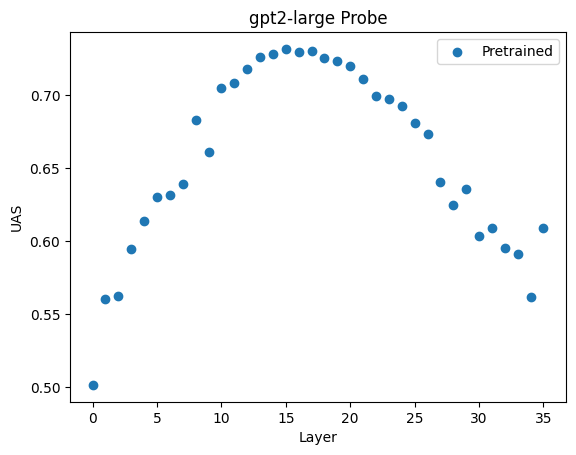

In [1]:
import matplotlib.pyplot as plt
import plot_utils

_MODEL_NAME = "gpt2-large"

all_probe_results = plot_utils.get_all_probe_results()
num_layers = len(all_probe_results[_MODEL_NAME])
kwargs = dict(
    x=range(num_layers),
    y=all_probe_results[_MODEL_NAME],
    label="Pretrained",
)
plt.scatter(**kwargs)    
plt.xlabel('Layer')
plt.ylabel('UAS')
plt.title(f"{_MODEL_NAME} Probe")
plt.legend()
plt.show()

### Probe vs SyntaxGym

In [6]:
import json
import run_registry
import numpy as np

all_scatter_kwargs = []
all_annotations = []
model_names = []

probe_results = plot_utils.get_best_probe_results()

for model_name, plot_name in plot_utils.PLOT_NAMES.items():
    with open(f'surprisals/{model_name.replace("/", "-")}.json') as f:
        surprisal_results = json.load(f)
        vals = []
        weights = []
        for file_name, value in surprisal_results.items():
            vals.append(value)
            weights.append(run_registry.sg_num_items[file_name])
        x = np.average(vals, weights=weights)
    kwargs = {}
    label = None
    # if 'gpt2' in model_name:
    #     kwargs['color'] = 'red'
    # elif 'pythia' in model_name:
    #     kwargs['color'] = 'green'
    model_type = plot_utils.get_model_type(model_name)
    kwargs |= dict(
        x=x,
        y=probe_results[model_name],
        s=80,
        marker=plot_utils.MARKER_MAPPING[model_type],
        color=plot_utils.COLOR_MAPPING[model_name],
    )
    xytext = (0, 10)
    if model_name == 'google/electra-small-generator':
        xytext=(40, -5)
    # if model_name == 'gpt2-large':
    #     xytext=(-40, -3)
    # if model_name == 'gpt2':
    #     xytext=(-20, -3)
    annotation = dict(
        text=plot_name,
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=xytext, ha='center'
    )
    all_annotations.append(annotation)

    all_scatter_kwargs.append(kwargs)
    model_names.append(model_name)

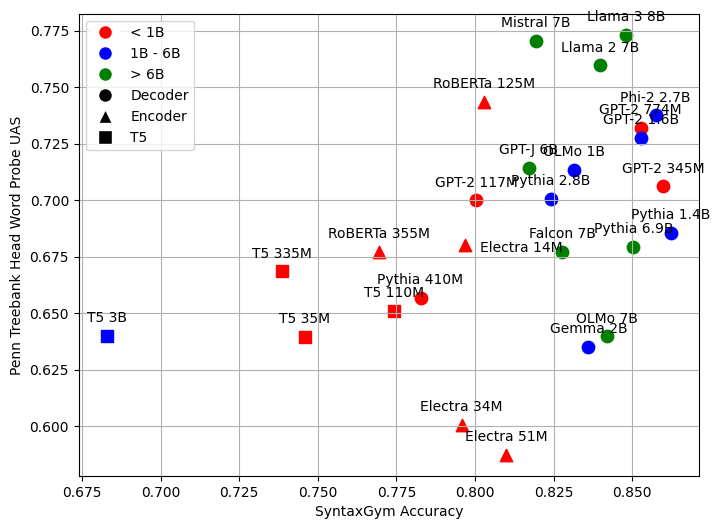

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plot_utils.plot(
    kwargs_list=all_scatter_kwargs,
    annotations_list=all_annotations,
    x_label='SyntaxGym Accuracy',
    y_label='Penn Treebank Head Word Probe UAS',
    title='',
    save_path='final_plots/probe_syntaxgym.png',
)

In [50]:
xs = [kwargs['x'] for kwargs in all_scatter_kwargs]
ys = [kwargs['y'] for kwargs in all_scatter_kwargs]
plot_utils.spearman(
    xs,
    ys,
    model_names,
    # specific_model_type=plot_utils.DECODER
)

(0.5019661553958669,
 PermutationTestResult(statistic=2.843286057113878, pvalue=0.0106, null_distribution=array([-0.34931607,  0.85534761,  1.97818782, ...,  3.315122  ,
        -0.4203264 ,  1.53226972])))

### SyntaxGym both axes

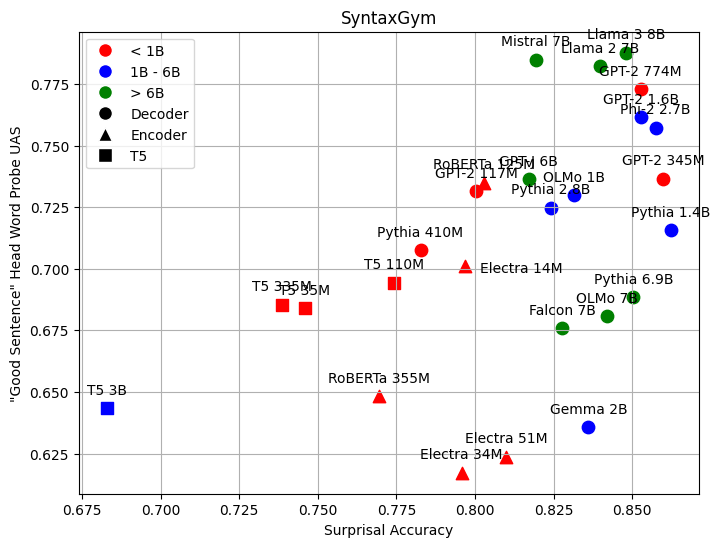

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import plot_utils
import run_registry

all_scatter_kwargs = []
all_annotations = []

for model_name, plot_name in plot_utils.PLOT_NAMES.items():
    # if "t5" in model_name or "roberta" in model_name or "electra" in model_name:
    #     continue
    with open(f'surprisals/{model_name.replace("/", "-")}.json') as f:
        surprisal_results = json.load(f)
        vals = []
        weights = []
        for file_name, value in surprisal_results.items():
            vals.append(value)
            weights.append(run_registry.sg_num_items[file_name])
        x = np.average(vals, weights=weights)
    with open(f'sg_probe/{model_name.replace("/", "-")}.json') as f:
        probe_results = json.load(f)
        vals = []
        weights = []
        for file_name, value in probe_results.items():
            vals.append(value)
            weights.append(run_registry.sg_num_items[file_name])
        y = np.average(vals, weights=weights)
    kwargs = {}
    label = None
    # if 'gpt2' in model_name:
    #     kwargs['color'] = 'red'
    # elif 'pythia' in model_name:
    #     kwargs['color'] = 'green'
    model_type = plot_utils.get_model_type(model_name)
    kwargs |= dict(
        x=x,
        y=y,
        s=80,
        marker=plot_utils.MARKER_MAPPING[model_type],
        color=plot_utils.COLOR_MAPPING[model_name],
    )
    xytext = (0, 10)
    if model_name == 'google/electra-small-generator':
        xytext=(40, -5)
    # if model_name == 'gpt2-large':
    #     xytext=(-40, -3)
    # if model_name == 'gpt2':
    #     xytext=(-20, -3)
    annotation = dict(
        text=plot_name,
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=xytext, ha='center'
    )
    all_annotations.append(annotation)

    all_scatter_kwargs.append(kwargs)

plot_utils.plot(
    kwargs_list=all_scatter_kwargs,
    annotations_list=all_annotations,
    x_label='Surprisal Accuracy',
    y_label='"Good Sentence" Head Word Probe UAS',
    title='SyntaxGym',
    save_path='final_plots/probe_syntaxgym.png',

)

## Probe vs BLiMP

In [58]:
import json
import numpy as np
import csv
import plot_utils
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


all_scatter_kwargs = []
all_annotations = []
model_names = []

for model_name, plot_name in plot_utils.PLOT_NAMES.items():
    blimp_results = plot_utils.get_blimp_aggregate_results(model_name)
    x = np.mean(list(blimp_results.values()))
    probe_results = plot_utils.get_best_probe_results()
    model_type = plot_utils.get_model_type(model_name)
    kwargs = dict(
        x=x,
        y=probe_results[model_name],
        s=80,
        marker=plot_utils.MARKER_MAPPING[model_type],
        color=plot_utils.COLOR_MAPPING[model_name],
    )
    xytext = (0, 10)
    # if model_name == 'google/electra-small-generator':
    #     xytext=(40, -5)
    # if model_name == 'gpt2-large':
    #     xytext=(-40, -3)
    # if model_name == 'gpt2':
    #     xytext=(-20, -3)
    annotation = dict(
        text=plot_name,
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=xytext, ha='center'
    )
    all_annotations.append(annotation)
    all_scatter_kwargs.append(kwargs)
    model_names.append(model_name)

# Create the scatter plot
# plt.figure(figsize=(8, 6))  # Set the figure size

# for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
#     plt.scatter(**kwargs)
#     plt.annotate(**annotations)

# plt.xlabel('BLiMP Accuracy')
# plt.ylabel('Head Word Probe UAS')

# # Add legend
# legend_elements = [
#     Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='< 1B'),
#     Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='1B - 6B'),
#     Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='> 6B'),
#     Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Decoder'),
#     Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=10, label='Encoder'),
#     Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=10, label='T5'),
# ]
# plt.legend(handles=legend_elements, loc='upper left')

# # Show the plot
# plt.grid(True)
# plt.savefig('final_plots/probe_blimp.png')
# plt.show()

xs = [kwargs['x'] for kwargs in all_scatter_kwargs]
ys = [kwargs['y'] for kwargs in all_scatter_kwargs]
plot_utils.spearman(
    xs,
    ys,
    model_names,
    specific_model_type=plot_utils.DECODER
)



(0.28186274509803927,
 PermutationTestResult(statistic=1.137781361895173, pvalue=0.2736, null_distribution=array([-0.95833114,  0.22821773,  0.37191466, ...,  1.20271358,
         0.14248542,  0.33347048])))

### Distractor Agreement Relational Noun

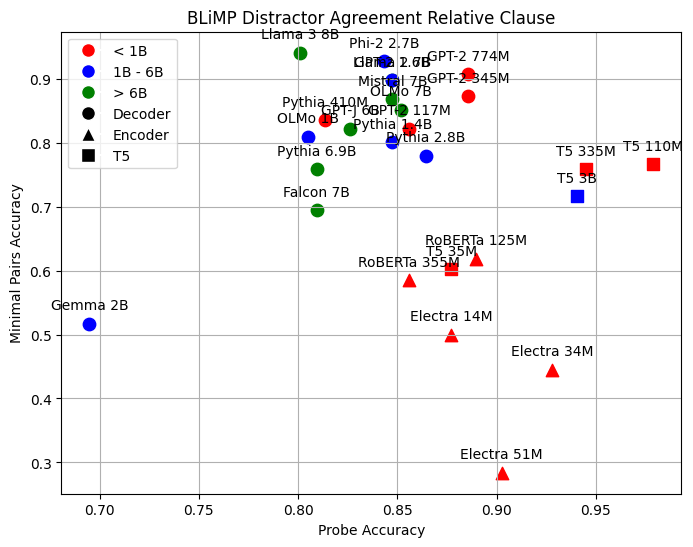

(-0.3387628173595521,
 PermutationTestResult(statistic=-1.763887581469859, pvalue=0.0884, null_distribution=array([ 0.92656466,  0.70772684, -0.81217657, ...,  0.21184618,
         0.20174073,  2.45937037])))

In [4]:
import plot_utils
import json

file_name = "distractor_agreement_relational_noun.jsonl"

xs = []
ys = []
all_scatter_kwargs = []
all_annotations = []
model_names = []
for model in plot_utils.PLOT_NAMES.keys():
    with open(f'blimp_probe/{model.replace("/", "-")}_agreement.json') as f:
        results = json.load(f)[file_name]
        xs.append(results['blimp_acc'])
        ys.append(results['probe_acc'])
    kwargs = dict(
        x=results['blimp_acc'],
        y=results['probe_acc'],
        s=80,
        marker=plot_utils.MARKER_MAPPING[plot_utils.get_model_type(model)],
        color=plot_utils.COLOR_MAPPING[model],
    )
    annotation = dict(
        text=plot_utils.PLOT_NAMES[model],
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=(0, 10), ha='center'
    )
    all_annotations.append(annotation)
    all_scatter_kwargs.append(kwargs)
    model_names.append(model)

plot_utils.plot(
    kwargs_list=all_scatter_kwargs,
    annotations_list=all_annotations,
    x_label='Probe Accuracy',
    y_label='Minimal Pairs Accuracy',
    title='BLiMP Distractor Agreement Relative Clause',
    save_path='final_plots/blimp_distractor_agreement_relative_clause.png',
)

plot_utils.spearman(xs, ys, model_names)


### Distractor Agreement Jaccard

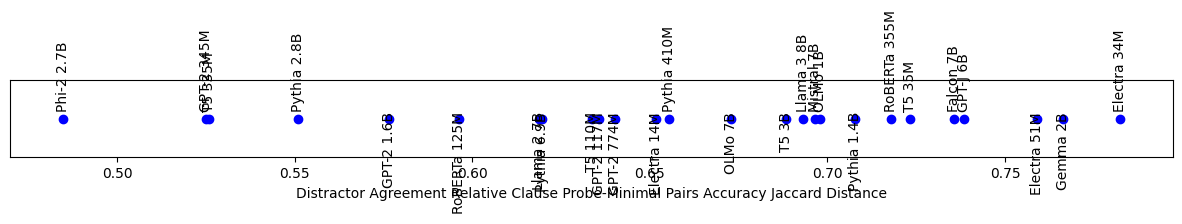

In [33]:
import matplotlib.pyplot as plt

jaccards = []
model_names = []
file_name = "distractor_agreement_relational_noun.jsonl"
file_name = "distractor_agreement_relative_clause.jsonl"
for model in plot_utils.PLOT_NAMES.keys():
    with open(f'blimp_probe/{model.replace("/", "-")}_agreement.json') as f:
        results = json.load(f)[file_name]
        jaccards.append(results['jaccard'])
    model_names.append(model)

values = jaccards
fig, ax = plt.subplots(figsize=(15, 1))
ax.plot(jaccards, [0] * len(values), 'bo')
ax.yaxis.set_visible(False)
# plt.xlim(0.15, 0.75)
plt.xlabel('Distractor Agreement Relative Clause Probe-Minimal Pairs Accuracy Jaccard Distance')

for model, value in zip(model_names, values):
    ax.text(value, 0.01, plot_utils.PLOT_NAMES[model], rotation=90, ha='center', va='bottom')

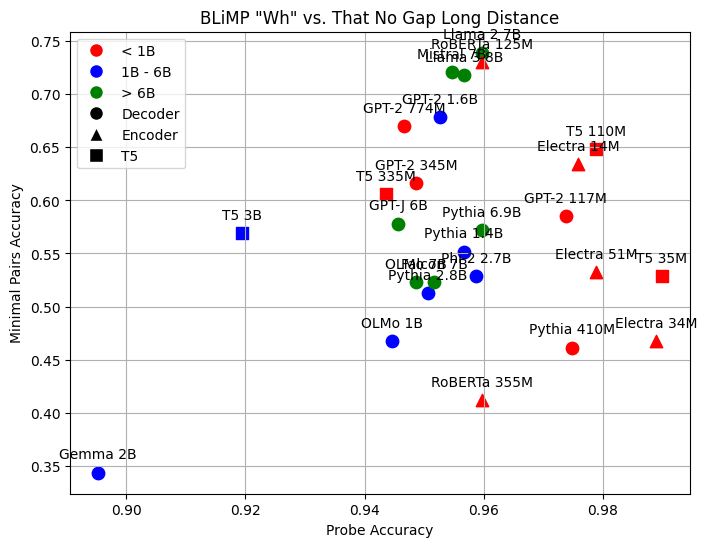

(0.2671992188296637,
 PermutationTestResult(statistic=1.0739038604616957, pvalue=0.2922, null_distribution=array([ 0.86024736,  1.0000008 ,  0.31986926, ..., -0.30545557,
         1.39874667, -0.56743405])))

In [12]:
import plot_utils
import json

file_name = "wh_vs_that_no_gap_long_distance.jsonl"

xs = []
ys = []
all_scatter_kwargs = []
all_annotations = []
model_names = []
for model in plot_utils.PLOT_NAMES.keys():
    with open(f'blimp_probe/{model.replace("/", "-")}_mark.json') as f:
        results = json.load(f)[file_name]
        xs.append(results['blimp_acc'])
        ys.append(results['probe_acc'])
    kwargs = dict(
        x=results['blimp_acc'],
        y=results['probe_acc'],
        s=80,
        marker=plot_utils.MARKER_MAPPING[plot_utils.get_model_type(model)],
        color=plot_utils.COLOR_MAPPING[model],
    )
    annotation = dict(
        text=plot_utils.PLOT_NAMES[model],
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=(0, 10), ha='center'
    )
    all_annotations.append(annotation)
    all_scatter_kwargs.append(kwargs)
    model_names.append(model)

plot_utils.plot(
    kwargs_list=all_scatter_kwargs,
    annotations_list=all_annotations,
    x_label='Probe Accuracy',
    y_label='Minimal Pairs Accuracy',
    title='BLiMP "Wh" vs. That No Gap Long Distance',
    save_path='final_plots/blimp_wh_vs_that_no_gap_long_distance.png',
)

plot_utils.spearman(xs, ys, model_names, specific_model_type=plot_utils.DECODER)


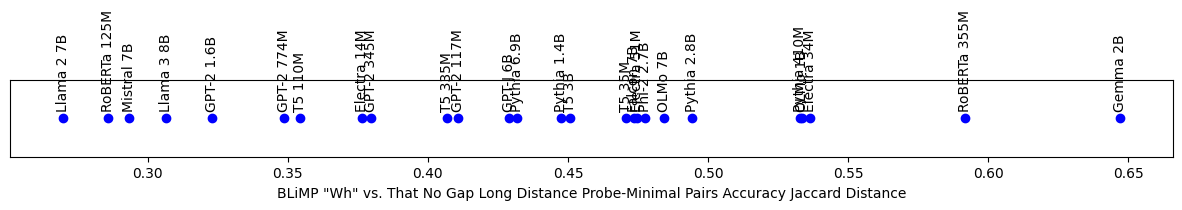

In [11]:
import matplotlib.pyplot as plt

jaccards = []
model_names = []
file_name = "wh_vs_that_no_gap_long_distance.jsonl"
for model in plot_utils.PLOT_NAMES.keys():
    with open(f'blimp_probe/{model.replace("/", "-")}_mark.json') as f:
        results = json.load(f)[file_name]
        jaccards.append(results['jaccard'])
    model_names.append(model)

values = jaccards
fig, ax = plt.subplots(figsize=(15, 1))
ax.plot(jaccards, [0] * len(values), 'bo')
ax.yaxis.set_visible(False)
# plt.xlim(0.15, 0.75)
plt.xlabel('BLiMP "Wh" vs. That No Gap Long Distance Probe-Minimal Pairs Accuracy Jaccard Distance')

for model, value in zip(model_names, values):
    ax.text(value, 0.01, plot_utils.PLOT_NAMES[model], rotation=90, ha='center', va='bottom')

### BLiMP Spearman

In [5]:
import dataclasses

@dataclasses.dataclass
class ResultsByModelType:
    decoder: list[tuple[float, float]] = dataclasses.field(default_factory=list)
    encoder: list[tuple[float, float]] = dataclasses.field(default_factory=list)
    encoder_decoder: list[tuple[float, float]] = dataclasses.field(default_factory=list)

In [49]:
import plot_utils
from scipy import stats
import json
import numpy as np

probe_results = plot_utils.get_best_probe_results()

linguistics_terms = {}
for model in plot_utils.PLOT_NAMES.keys():
    blimp_results = plot_utils.get_blimp_aggregate_results(model)
    probe_result = probe_results[model]
    for key, value in blimp_results.items():
        if key not in linguistics_terms:
            print(key)
            linguistics_terms[key] = ResultsByModelType()
        getattr(linguistics_terms[key], plot_utils.get_model_type(model)).append((value, probe_result))

combos = [
    "all",
    # plot_utils.ENCODER,
    plot_utils.DECODER,
    # plot_utils.ENCODER_DECODER
]

correction = len(linguistics_terms)
print(correction, linguistics_terms)
for model_type in combos:
    with open(f"spearman/blimp_{model_type}.json", "w") as f:
        term_statistic_dict = {}
        
        for term, model_results in linguistics_terms.items():
            if model_type == "all":
                results = model_results.decoder + model_results.encoder + model_results.encoder_decoder
            else:
                results = getattr(model_results, model_type)
            
            xs, ys = zip(*results)
            spearman, p_value = plot_utils.spearman(xs, ys, plot_utils.PLOT_NAMES.keys())
            p_value = p_value.pvalue * correction 
            term_statistic_dict[term] = {
                'correlation': spearman,
                'pvalue': p_value,
            }
        json.dump(term_statistic_dict, f)

island_effects
anaphor_agreement
s-selection
argument_structure
determiner_noun_agreement
subject_verb_agreement
ellipsis
control_raising
quantifiers
irregular_forms
npi_licensing
binding
filler_gap_dependency
13 {'island_effects': ResultsByModelType(decoder=[(0.6597500000000001, 0.6395502209325331), (0.77, 0.6508111851216778), (0.786875, 0.6684857877728682), (0.81575, 0.63979753346963)], encoder=[(0.717625, 0.6802743520411528), (0.7553749999999999, 0.6004583525687529), (0.7304999999999999, 0.5873013255951989), (0.8336250000000001, 0.6769768515465278), (0.80675, 0.7434049990107499)], encoder_decoder=[(0.6475, 0.6567466860120029), (0.6855, 0.6855833278374992), (0.691875, 0.7005210050781507), (0.739625, 0.6791861768779265), (0.750625, 0.677141726571259), (0.691875, 0.7318802347820352), (0.6298750000000001, 0.7060278309041746), (0.608375, 0.6998285299742795), (0.713625, 0.7141561696234254), (0.7277499999999999, 0.7595627514344128), (0.7228749999999999, 0.773148453472268), (0.68275, 0.7275

### Blimp subplots

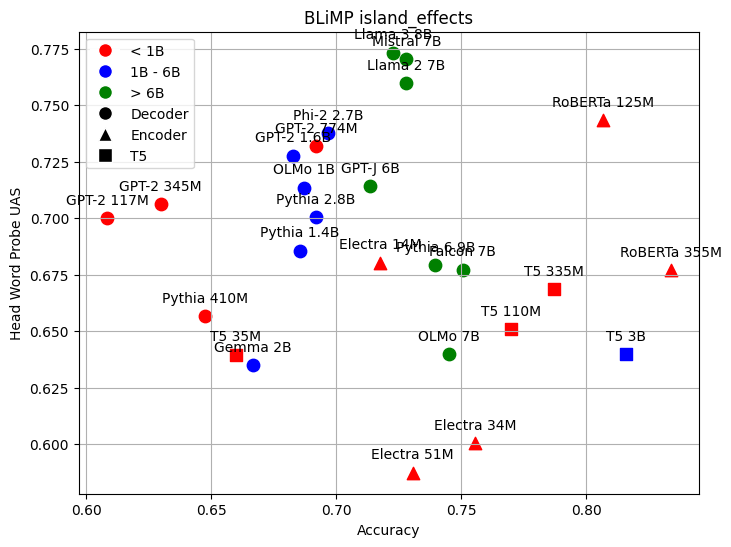

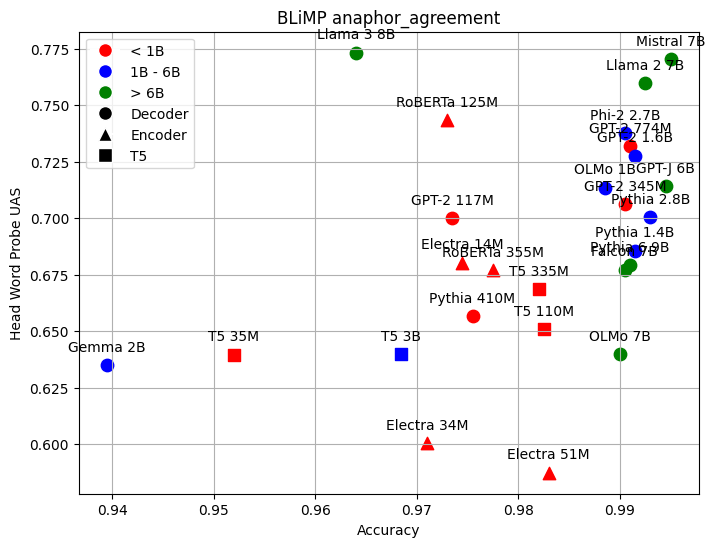

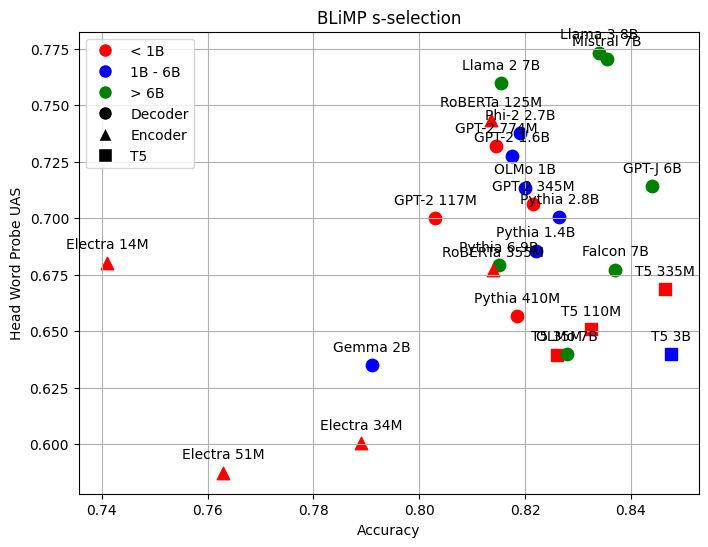

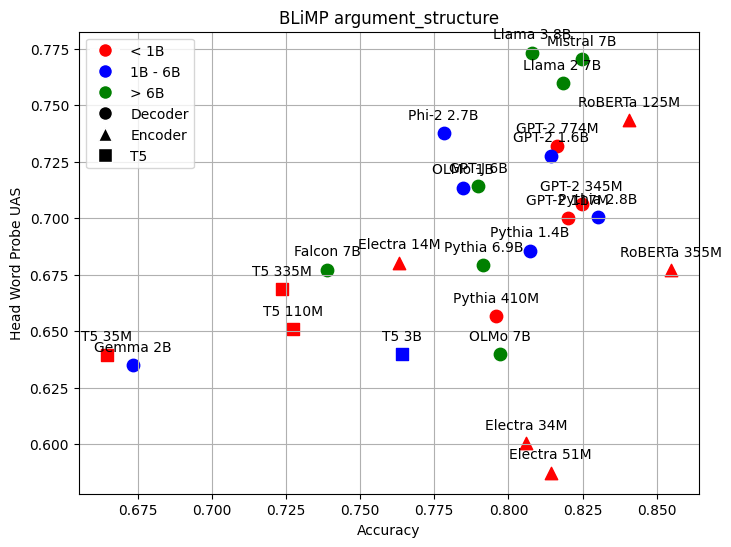

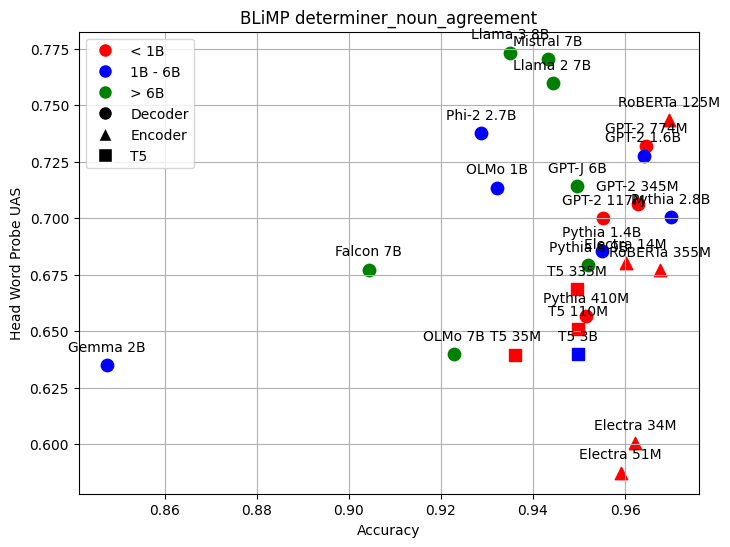

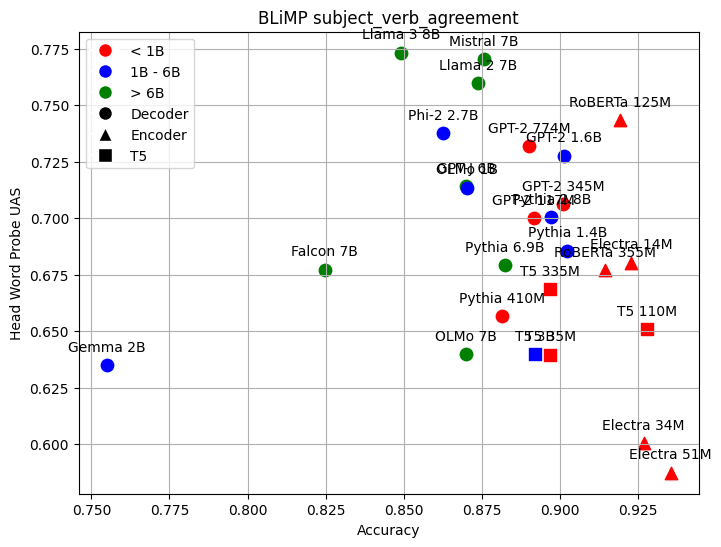

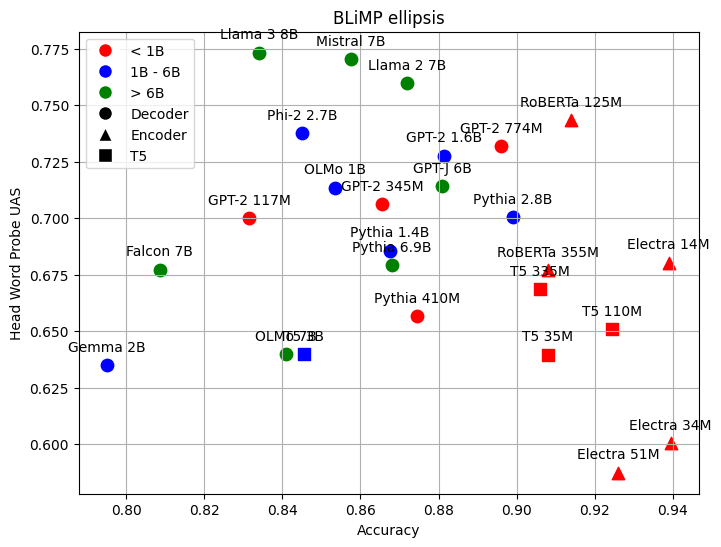

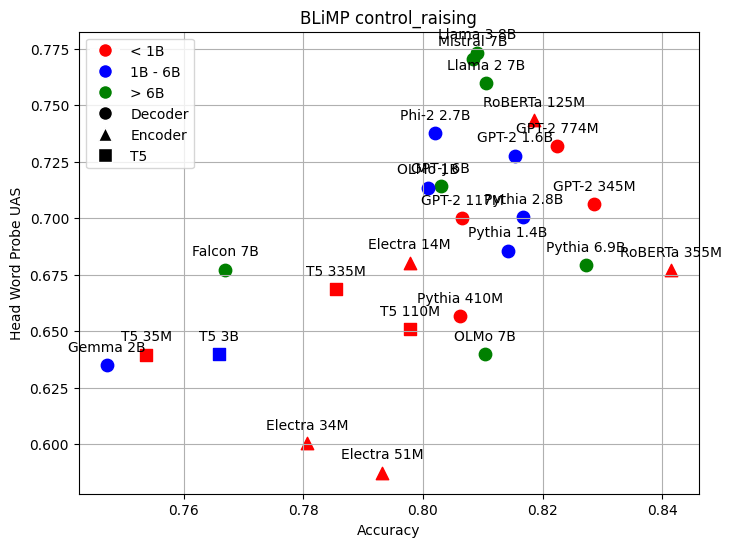

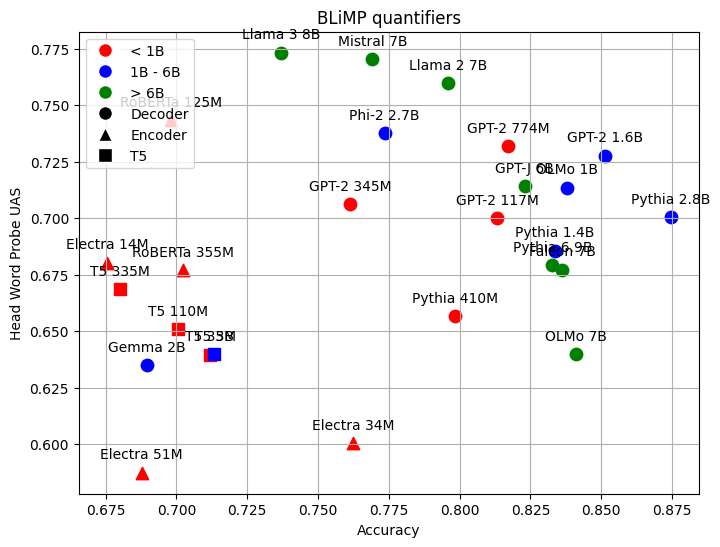

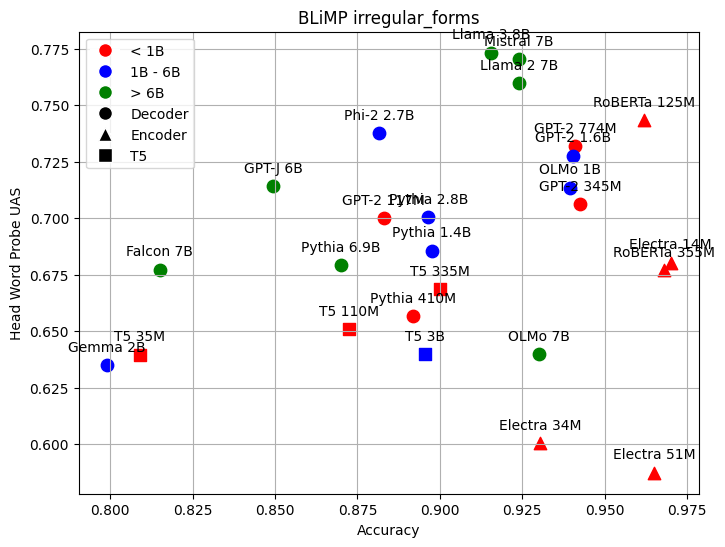

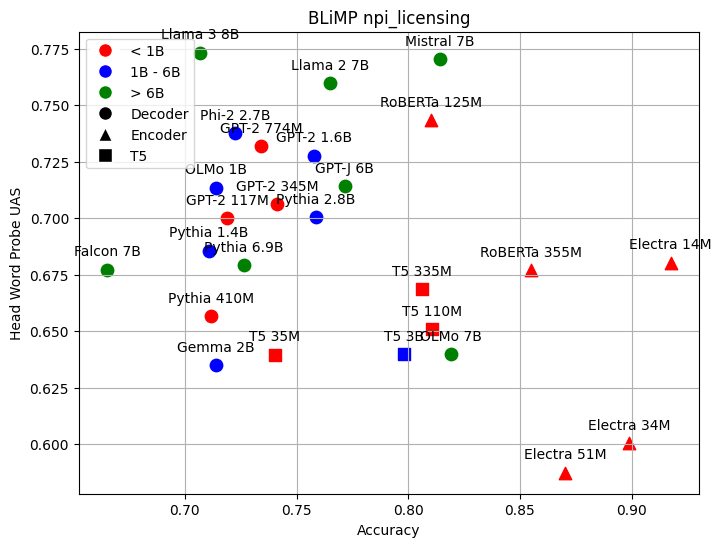

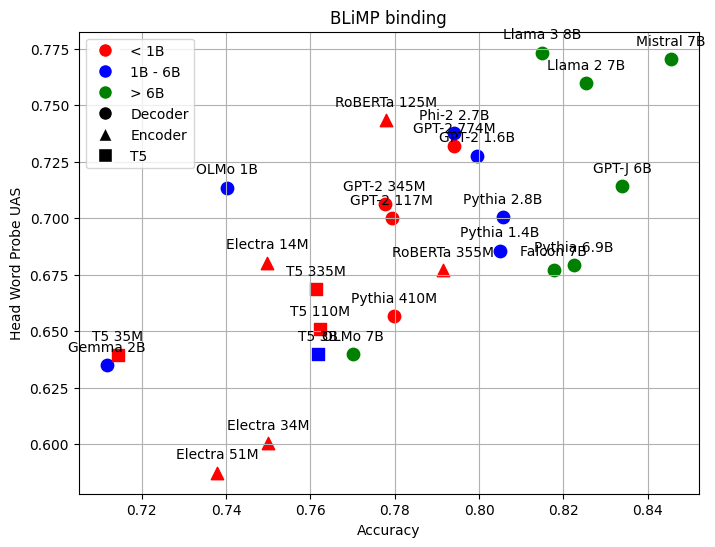

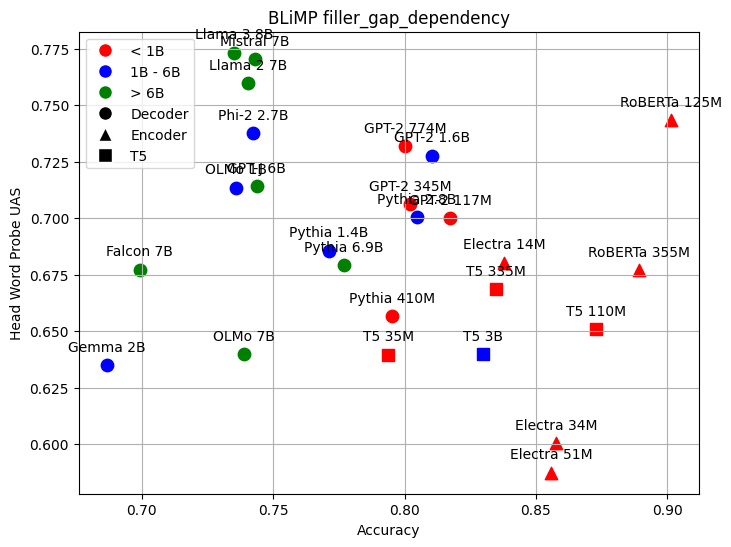

In [56]:
vals = {}
for model_name, plot_name in plot_names.items():
    with open(f'blimp_results/{model_name.replace("/", "_")}_aggregate.csv') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["linguistics_term"] not in vals:
                vals[row["linguistics_term"]] = {}
            vals[row["linguistics_term"]][model_name] = float(row["accuracy"])

for linguistics_term, models in vals.items():
    all_annotations = []
    all_scatter_kwargs = []
    for model_name, accuracy in models.items():
        kwargs = {
            'x': accuracy,
            'y': probe_results[model_name],
            's': 80,
            'marker': get_marker(model_name),
            'color': color_mapping[model_name],
        }
        all_scatter_kwargs.append(kwargs)
        all_annotations.append(dict(
            text=plot_names[model_name],
            xy=(kwargs['x'], kwargs['y']),
            textcoords="offset points",
            xytext=(0, 10), ha='center'
        ))
    plt.figure(figsize=(8, 6))  # Set the figure size

    for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
        plt.scatter(**kwargs)
        plt.annotate(**annotations)

        plt.title(f'BLiMP {linguistics_term}')
        plt.xlabel(f'Accuracy')
        plt.ylabel('Head Word Probe UAS')
        plt.grid(True)
        plt.legend(handles=legend_elements, loc='upper left')
        plt.savefig(f'final_plots/blimp/{linguistics_term}.png')

    

## Blimp vs SG

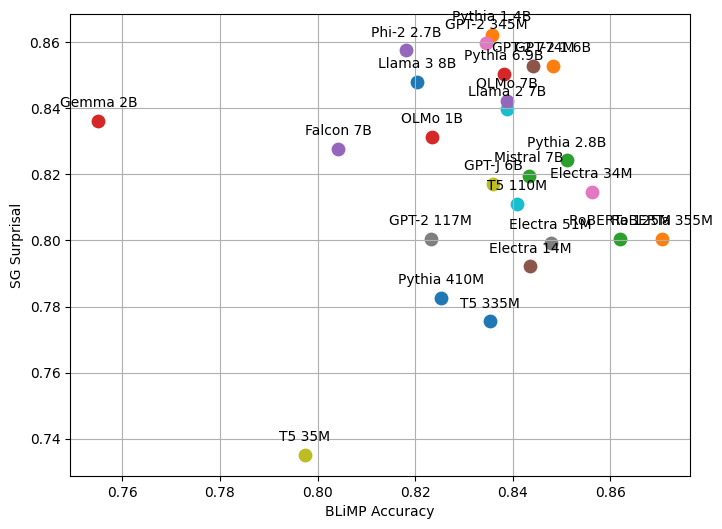

In [58]:
import run_registry
import json
import csv
import numpy as np
import matplotlib.pyplot as plt


all_scatter_kwargs = []
all_annotations = []
for model_name, plot_name in plot_names.items():
    if 't5-3b' in model_name:
        continue
    with open(f'blimp_results/{model_name.replace("/", "_")}_aggregate.csv') as f:
        reader = csv.DictReader(f)
        vals = []
        for row in reader:
            vals.append(float(row["accuracy"]))
        x = np.mean(vals)
    with open(f'surprisals/{model_name.replace("/", "-")}.json') as f:
        surprisal_results = json.load(f)
        vals = []
        weights = []
        for file_name, value in surprisal_results.items():
            vals.append(value)
            weights.append(run_registry.sg_num_items[file_name])
        y = np.average(vals, weights=weights)
    kwargs = {
        'x': x,
        'y': y,
        's': 80
    }
    all_scatter_kwargs.append(kwargs)
    all_annotations.append(dict(
        text=plot_names[model_name],
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=(0, 10), ha='center'
    ))

plt.figure(figsize=(8, 6))  # Set the figure size

for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
    plt.scatter(**kwargs)
    plt.annotate(**annotations)

plt.xlabel('BLiMP Accuracy')
plt.ylabel('SG Surprisal')
plt.grid(True)
plt.savefig(f'final_plots/blimp_sg.png')

### Specific linguistic phenomena

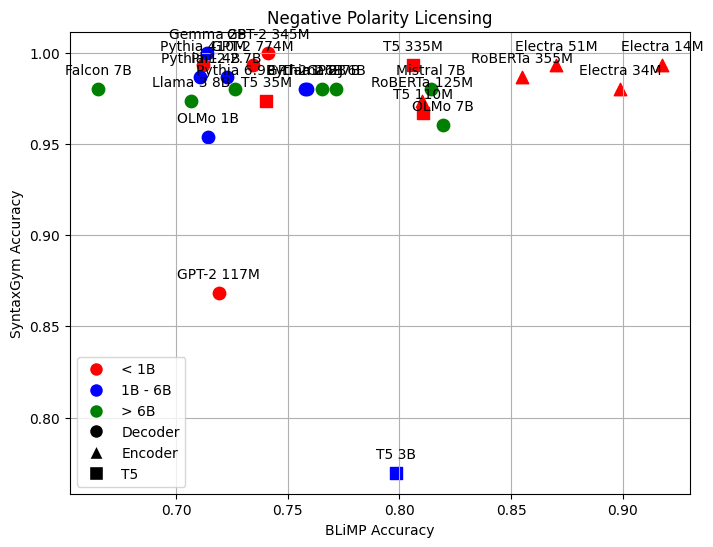

In [73]:
import run_registry
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import dataclasses

@dataclasses.dataclass
class Phenomena:
    name: str
    sg_str_match: str
    blimp_str_match: str

phenomena_of_intest = [
    Phenomena('NPI', 'npi', 'npi'),
    # Phenomena('Anaphor', 'reflexive', 'anaphor'),
    # Phenomena('FGP', 'fgd', 'filler_gap_dependency')
    # Phenomena('Subject Verb Agreement', 'number_', 'subject_verb_agreement')
]

for phenomena in phenomena_of_intest:
    all_scatter_kwargs = []
    all_annotations = []
    for model_name, plot_name in plot_names.items():
        # if 'bert' in model_name or 't5' in model_name or 'electra' in model_name:
        #     continue
        with open(f'blimp_results/{model_name.replace("/", "_")}_aggregate.csv') as f:
            reader = csv.DictReader(f)
            vals = []
            for row in reader:
                if phenomena.blimp_str_match in row["linguistics_term"]:
                    vals.append(float(row["accuracy"]))
            assert len(vals) == 1
            x = vals[0]
        with open(f'surprisals/{model_name.replace("/", "-")}.json') as f:
            surprisal_results = json.load(f)
            vals = []
            weights = []
            for file_name, value in surprisal_results.items():
                if phenomena.sg_str_match in file_name:
                    vals.append(value)
                    weights.append(run_registry.sg_num_items[file_name])
            y = np.average(vals, weights=weights)
        kwargs = {
            'x': x,
            'y': y,
            's': 80,
            'marker': get_marker(model_name),
            'color': color_mapping[model_name],
        }
        all_scatter_kwargs.append(kwargs)
        all_annotations.append(dict(
            text=plot_names[model_name],
            xy=(kwargs['x'], kwargs['y']),
            textcoords="offset points",
            xytext=(0, 10), ha='center'
        ))

    plt.figure(figsize=(8, 6))  # Set the figure size

    for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
        plt.scatter(**kwargs)
        plt.annotate(**annotations)

    plt.title("Negative Polarity Licensing")
    plt.xlabel('BLiMP Accuracy')
    plt.ylabel('SyntaxGym Accuracy')
    plt.grid(True)
    plt.legend(handles=legend_elements, loc='lower left')
    plt.savefig(f'final_plots/blimp_sg_{phenomena.name}.png')

### Det accuracy vs. BLiMP

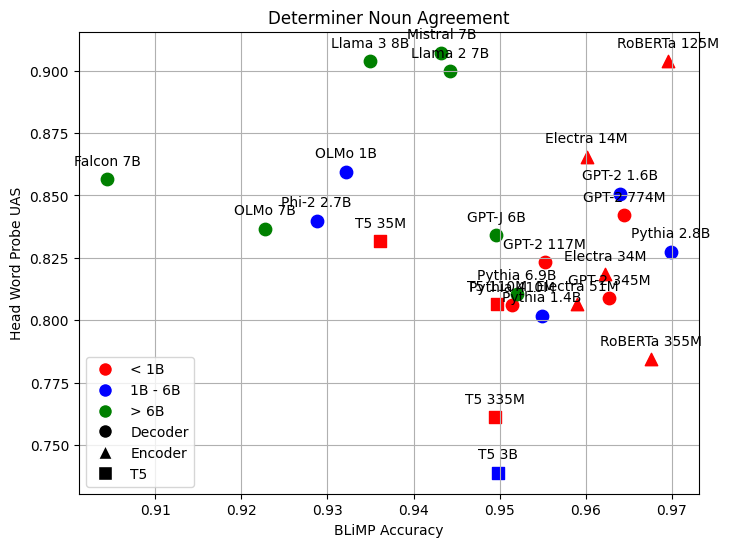

In [69]:
all_scatter_kwargs = []
all_annotations = []
for model_name, run_id in run_registry.RUNS.items():
    run = api.run(run_id)
    det_correct = run.summary_metrics["det_correct"]
    det_total = run.summary_metrics["det_total"]
    y = det_correct / det_total
    if 'gemma' in model_name:
        continue

    with open(f'blimp_results/{model_name.replace("/", "_")}_aggregate.csv') as f:
        reader = csv.DictReader(f)
        vals = []
        for row in reader:
            if row["linguistics_term"] == "determiner_noun_agreement":
                vals.append(float(row["accuracy"]))
        assert len(vals) == 1
        x = vals[0]
    
    if model_name not in plot_names:
        continue
    kwargs = {
        'x': x,
        'y': y,
        's': 80,
        'marker': get_marker(model_name),
        'color': color_mapping[model_name],
    }
    all_scatter_kwargs.append(kwargs)
    all_annotations.append(dict(
        text=plot_names[model_name],
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=(0, 10), ha='center'
    ))

plt.figure(figsize=(8, 6))  # Set the figure size

for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
    plt.scatter(**kwargs)
    plt.annotate(**annotations)

plt.title('Determiner Noun Agreement')
plt.xlabel('BLiMP Accuracy')
plt.ylabel('Head Word Probe UAS')
plt.grid(True)
plt.legend(handles=legend_elements, loc='lower left')
plt.savefig(f'final_plots/det_agreement.png')


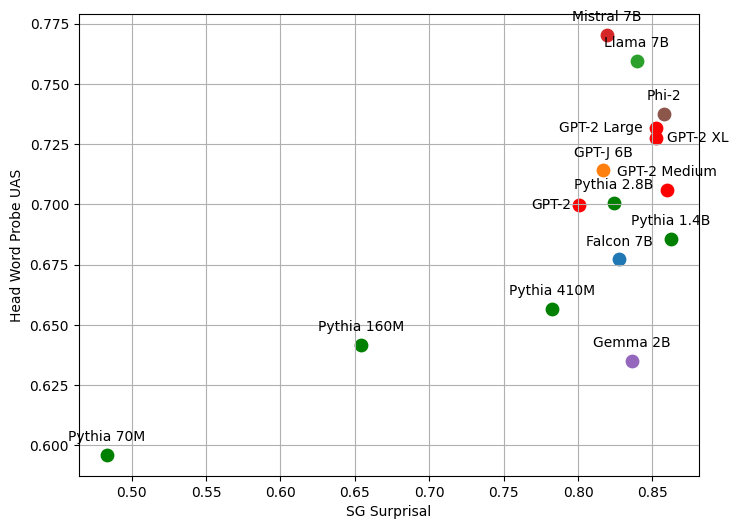

In [11]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size

for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
    plt.scatter(**kwargs)
    plt.annotate(**annotations)

plt.xlabel('SG Surprisal')
plt.ylabel('Head Word Probe UAS')

# Add legend
# plt.legend()


# Show the plot
plt.grid(True)
plt.savefig('final_plots/weighted_average.png')
# plt.show()

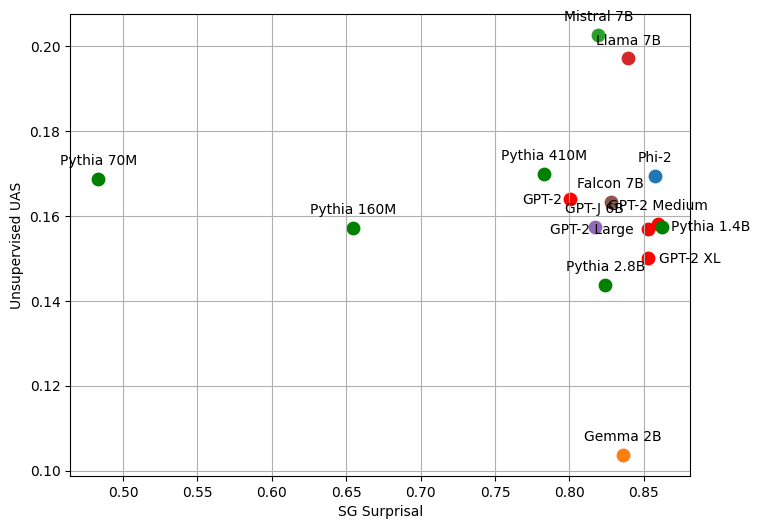

In [14]:
import json
all_scatter_kwargs = []
all_annotations = []
for model_name, unsup_value in unsupervised_results.items():
    with open(f'surprisals/{model_name.replace("/", "-")}.json') as f:
        surprisal_results = json.load(f)
        vals = []
        weights = []
        for file_name, value in surprisal_results.items():
            vals.append(value)
            weights.append(sg_num_items[file_name])
        x = np.average(vals, weights=weights)
    kwargs = {}
    label = None
    if 'gpt2' in model_name:
        kwargs['color'] = 'red'
    elif 'pythia' in model_name:
        kwargs['color'] = 'green'
    kwargs |= dict(
        x=x,
        y=unsup_value,
        s=80
    )
    xytext = (0, 10)
    if model_name == 'gpt2-xl':
        xytext=(30, -3)
    if model_name == "EleutherAI/pythia-1.4b":
        xytext=(35, -3)
    if model_name == 'gpt2-large':
        xytext=(-40, -3)
    if model_name == 'gpt2':
        xytext=(-20, -3)
    annotation = dict(
        text=plot_names[model_name],
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=xytext, ha='center'
    )
    all_annotations.append(annotation)

    
    all_scatter_kwargs.append(kwargs)

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size

for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
    plt.scatter(**kwargs)
    plt.annotate(**annotations)

plt.xlabel('SG Surprisal')
plt.ylabel('Unsupervised UAS')

# Add legend
# plt.legend()


# Show the plot
plt.grid(True)
plt.savefig('final_plots/unsupervised_weighted_average.png')
# plt.show()

In [2]:
sorted_sg_mapping = dict(sorted(sg_mapping.items(), key=lambda x: x[0]))

print(sorted_sg_mapping)


{'center_embed.json': 'Center Embedding', 'center_embed_mod.json': 'Center Embedding', 'cleft.json': 'Long-Distance Dependencies', 'cleft_modifier.json': 'Long-Distance Dependencies', 'fgd-embed3.json': 'Long-Distance Dependencies', 'fgd-embed4.json': 'Long-Distance Dependencies', 'fgd_hierarchy.json': 'Long-Distance Dependencies', 'fgd_object.json': 'Long-Distance Dependencies', 'fgd_pp.json': 'Long-Distance Dependencies', 'fgd_subject.json': 'Long-Distance Dependencies', 'mvrr.json': 'Garden-Path Effects', 'mvrr_mod.json': 'Garden-Path Effects', 'npi_orc_any.json': 'Licensing', 'npi_orc_ever.json': 'Licensing', 'npi_src_any.json': 'Licensing', 'npi_src_ever.json': 'Licensing', 'npz_ambig.json': 'Garden-Path Effects', 'npz_ambig_mod.json': 'Garden-Path Effects', 'npz_obj.json': 'Garden-Path Effects', 'npz_obj_mod.json': 'Garden-Path Effects', 'number_orc.json': 'Agreement', 'number_prep.json': 'Agreement', 'number_src.json': 'Agreement', 'reflexive_orc_fem.json': 'Licensing', 'reflexi

In [13]:
sg_mapping = {
    "fgd_hierarchy.json": "Long-Distance Dependencies",
    "subordination_src-src.json": "Gross Syntactic State",
    "reflexive_src_fem.json": "Licensing",
    "npz_obj_mod.json": "Garden-Path Effects",
    "npi_src_any.json": "Licensing",
    "reflexive_prep_fem.json": "Licensing",
    "fgd-embed3.json": "Long-Distance Dependencies",
    "subordination.json": "Gross Syntactic State",
    "reflexive_prep_masc.json": "Licensing",
    "cleft_modifier.json": "Long-Distance Dependencies",
    "fgd_subject.json": "Long-Distance Dependencies",
    "mvrr.json": "Garden-Path Effects",
    "npi_src_ever.json": "Licensing",
    "npz_ambig.json": "Garden-Path Effects",
    "cleft.json": "Long-Distance Dependencies",
    "npi_orc_ever.json": "Licensing",
    "mvrr_mod.json": "Garden-Path Effects",
    "center_embed.json": "Center Embedding",
    "fgd-embed4.json": "Long-Distance Dependencies",
    "reflexive_src_masc.json": "Licensing",
    "subordination_pp-pp.json": "Gross Syntactic State",
    "subordination_orc-orc.json": "Gross Syntactic State",
    "number_orc.json": "Agreement",
    "npz_obj.json": "Garden-Path Effects",
    "reflexive_orc_masc.json": "Licensing",
    "number_prep.json": "Agreement",
    "fgd_object.json": "Long-Distance Dependencies",
    "npz_ambig_mod.json": "Garden-Path Effects",
    "center_embed_mod.json": "Center Embedding",
    "number_src.json": "Agreement",
    "reflexive_orc_fem.json": "Licensing",
    "fgd_pp.json": "Long-Distance Dependencies",
    "npi_orc_any.json": "Licensing",
}

probe_results = plot_utils.get_best_probe_results()

def get_kwargs_for_test_suite(test_suite):
    all_annotations = []
    all_scatter_kwargs = []
    for model_name, plot_name in plot_utils.PLOT_NAMES.items():
        with open(f'surprisals/{model_name.replace("/", "-")}.json') as f:
            surprisal_results = json.load(f)
            vals = []
            weights = []
            for file_name, value in surprisal_results.items():
                if 'nn-nv-rpl' in file_name:
                    continue
                if sg_mapping[file_name] == test_suite:
                    vals.append(value)
                    weights.append(run_registry.sg_num_items[file_name])
            x = np.average(vals, weights=weights)

        kwargs = dict(
            x=x,
            y=probe_results[model_name],
            s=80,
            marker=plot_utils.MARKER_MAPPING[model_type],
            color=plot_utils.COLOR_MAPPING[model_name],
        )   
        xytext = (0, 10)
        # if model_name == 'gpt2-xl':
        #     xytext=(30, -3)
        # if model_name == 'gpt2-large':
        #     xytext=(-40, -3)
        # if model_name == 'gpt2':
        #     xytext=(-20, -3)
        annotation = dict(
            text=plot_name,
            xy=(kwargs['x'], kwargs['y']),
            textcoords="offset points",
            xytext=xytext, ha='center'
        )
        all_annotations.append(annotation)
        all_scatter_kwargs.append(kwargs)
    return all_scatter_kwargs, all_annotations

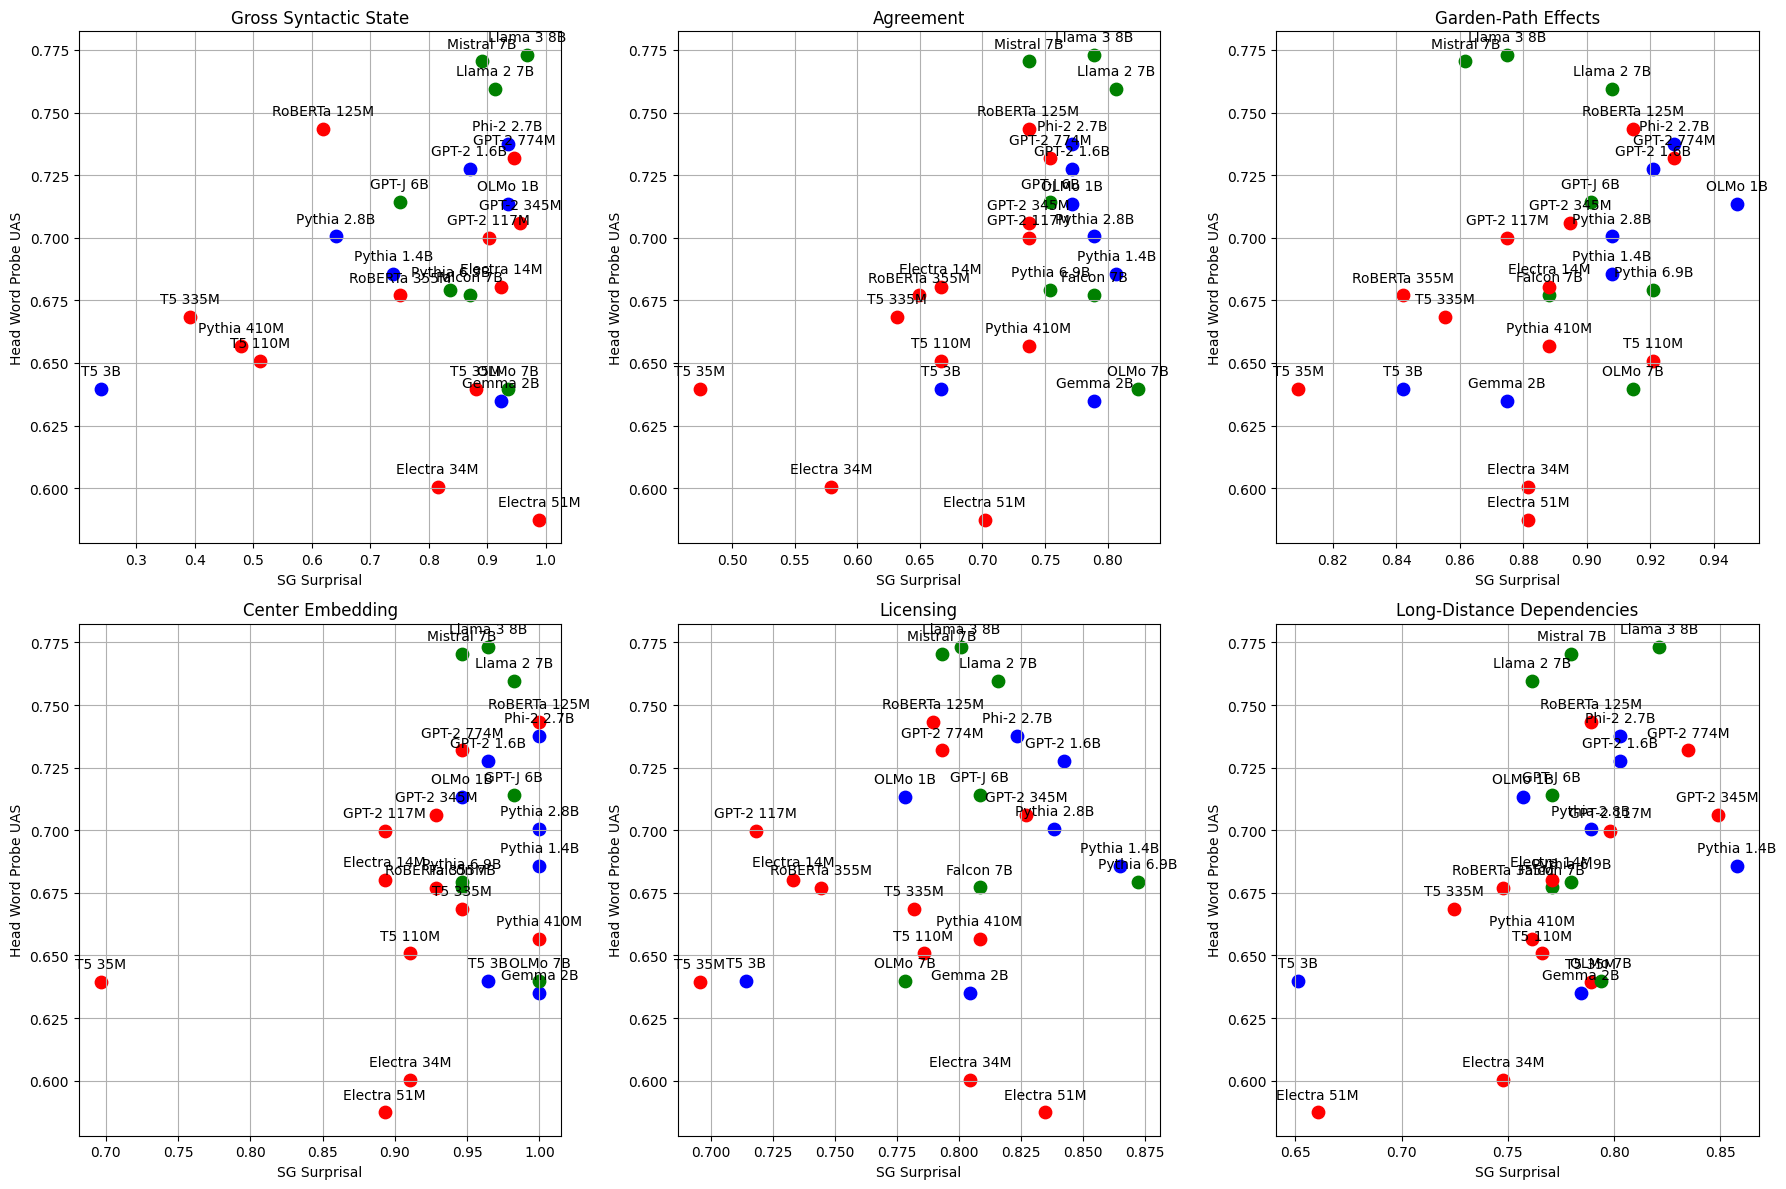

In [14]:
test_suites = set(sg_mapping.values())
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for i, test_suite in enumerate(test_suites):
    all_scatter_kwargs, all_annotations = get_kwargs_for_test_suite(test_suite)
    ax = axs[i % 2, i // 2]  # Swap the row and column indices

    for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
        ax.scatter(**kwargs)
        ax.annotate(**annotations)

    ax.set_xlabel('SG Surprisal')
    ax.set_ylabel('Head Word Probe UAS')
    ax.set_title(test_suite)
    ax.grid(True)

plt.tight_layout()
plt.savefig('final_plots/grid.png')


In [16]:
for test_suite in test_suites:
    all_scatter_kwargs, all_annotations = get_kwargs_for_test_suite(test_suite)
    xs = [kwargs['x'] for kwargs in all_scatter_kwargs]
    ys = [kwargs['y'] for kwargs in all_scatter_kwargs]
    model_names = [annotation['text'] for annotation in all_annotations]
    spearman, p_value = plot_utils.spearman(
        xs,
        ys,
        model_names,
    )
    print(test_suite, spearman, p_value.pvalue * len(test_suites))
    decoder_only_spearman, decoder_only_p_value = plot_utils.spearman(
        xs,
        ys,
        model_names,
        specific_model_type=plot_utils.DECODER
    )
    print("Decoder", test_suite, decoder_only_spearman, decoder_only_p_value.pvalue * len(test_suites))


Gross Syntactic State 0.21872341556030772 1.7519999999999998
Decoder Gross Syntactic State 0.3712371556034487 0.8736
Center Embedding 0.29858563750784345 0.8280000000000001
Decoder Center Embedding -0.25286406137966744 1.9367999999999999
Agreement 0.408828153631239 0.23399999999999999
Decoder Agreement -0.14225659382146938 3.4116
Licensing 0.2118776122563857 1.7664
Decoder Licensing -0.03813064090519855 5.3052
Garden-Path Effects 0.3797620974095351 0.3336
Decoder Garden-Path Effects 0.08760226377879403 4.461600000000001
Long-Distance Dependencies 0.4789321525645849 0.10439999999999999
Decoder Long-Distance Dependencies 0.15479162201961869 3.2807999999999997


In [33]:
with open('llama_surprisal.json', 'r') as f:
    llama_surprisal_results = json.load(f)
llama_surprisal_results = [np.mean(list(task_surprisal.values())) for k, task_surprisal in llama_surprisal_results.items()]

with open('EleutherAI_pythia_surprisal.json', 'r') as f:
    pythia_surprisal_results = json.load(f)
pythia_surprisal_results = [np.mean(list(task_surprisal.values())) for k, task_surprisal in pythia_surprisal_results.items()]


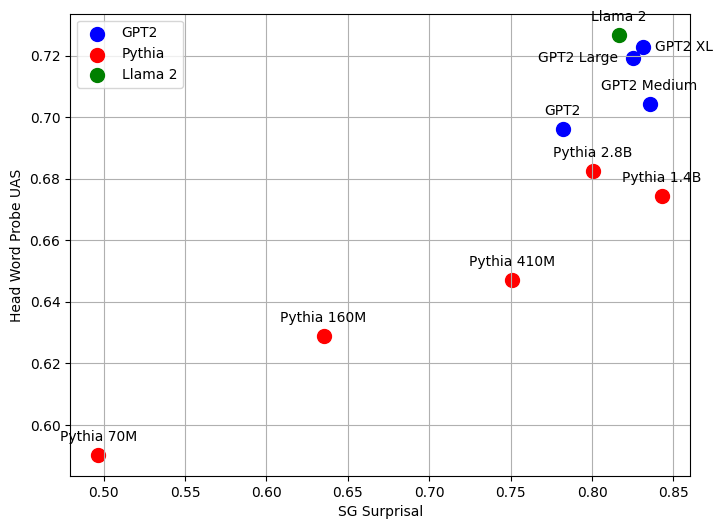

In [54]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the first set of points in blue
plt.scatter(gpt_surprisal_results, gpt_probe_results, color='blue', label='GPT2', s=100)  # Set marker size to 100
gpt_labels = ['GPT2', 'GPT2 Medium', 'GPT2 Large', 'GPT2 XL']

# Plot the second set of points in red
plt.scatter(pythia_surprisal_results, pythia_probe_results, color='red', label='Pythia', s=100)
pythia_labels = ['Pythia 70M', 'Pythia 160M', 'Pythia 410M', 'Pythia 1.4B', 'Pythia 2.8B']

plt.scatter(llama_surprisal_results, llama_probe_results, color='green', label='Llama 2', s=100)
llama_labls = ['Llama 2']

# Add labels to each data point
for i, txt in enumerate(gpt_labels):
    plt.annotate(txt, (gpt_surprisal_results[i], gpt_probe_results[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    if i == 1:
        break

plt.annotate('GPT2 Large', (gpt_surprisal_results[2], gpt_probe_results[2]), textcoords="offset points", xytext=(-40, -3), ha='center')
plt.annotate('GPT2 XL', (gpt_surprisal_results[3], gpt_probe_results[3]), textcoords="offset points", xytext=(30, -3), ha='center')


for i, txt in enumerate(pythia_labels):
    plt.annotate(txt, (pythia_surprisal_results[i], pythia_probe_results[i]), textcoords="offset points", xytext=(0, 10), ha='center')

for i, txt in enumerate(llama_labls):
    plt.annotate(txt, (llama_surprisal_results[i], llama_probe_results[i]), textcoords="offset points", xytext=(0, 10), ha='center')
# Add labels and title
plt.xlabel('SG Surprisal')
plt.ylabel('Head Word Probe UAS')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [16]:
with open('surprisals/meta-llama-Llama-2-7b-hf.json'):
    llama_surprisal_results = json.load(f)


NameError: name 'json' is not defined

In [17]:
gpt_surprisal_results

NameError: name 'gpt_surprisal_results' is not defined

In [13]:
import os

out = {}
for file_name in os.listdir('sg_test_suites'):
    if 'fgd' in file_name or 'cleft' in file_name:
        out[file_name] = 'Long-Distance Dependencies'
    elif 'subordination' in file_name:
        out[file_name] = 'Gross Syntactic State'
    elif 'center_embed' in file_name:
        out[file_name] = 'Center Embedding'
    elif 'reflexive' in file_name or 'npi_' in file_name:
        out[file_name] = 'Licensing'
    elif 'mvrr' in file_name or 'npz' in file_name:
        out[file_name] = 'Garden-Path Effects'
    elif 'number' in file_name:
        out[file_name] = 'Agreement'
    else:
        print(file_name)

nn-nv-rpl.json


In [14]:
out

{'fgd_hierarchy.json': 'Long-Distance Dependencies',
 'subordination_src-src.json': 'Gross Syntactic State',
 'reflexive_src_fem.json': 'Licensing',
 'npz_obj_mod.json': 'Garden-Path Effects',
 'npi_src_any.json': 'Licensing',
 'reflexive_prep_fem.json': 'Licensing',
 'fgd-embed3.json': 'Long-Distance Dependencies',
 'subordination.json': 'Gross Syntactic State',
 'reflexive_prep_masc.json': 'Licensing',
 'cleft_modifier.json': 'Long-Distance Dependencies',
 'fgd_subject.json': 'Long-Distance Dependencies',
 'mvrr.json': 'Garden-Path Effects',
 'npi_src_ever.json': 'Licensing',
 'npz_ambig.json': 'Garden-Path Effects',
 'cleft.json': 'Long-Distance Dependencies',
 'npi_orc_ever.json': 'Licensing',
 'mvrr_mod.json': 'Garden-Path Effects',
 'center_embed.json': 'Center Embedding',
 'fgd-embed4.json': 'Long-Distance Dependencies',
 'reflexive_src_masc.json': 'Licensing',
 'subordination_pp-pp.json': 'Gross Syntactic State',
 'subordination_orc-orc.json': 'Gross Syntactic State',
 'number_

In [49]:
weights = {}
for file_name in os.listdir('sg_test_suites'):
    with open(f'sg_test_suites/{file_name}', 'r') as f:
        data = json.load(f)
        weights[file_name] = len(data['items'])

In [50]:
weights

{'fgd_hierarchy.json': 24,
 'subordination_src-src.json': 23,
 'reflexive_src_fem.json': 19,
 'npz_obj_mod.json': 24,
 'npi_src_any.json': 38,
 'reflexive_prep_fem.json': 19,
 'fgd-embed3.json': 21,
 'subordination.json': 23,
 'reflexive_prep_masc.json': 19,
 'cleft_modifier.json': 40,
 'fgd_subject.json': 24,
 'mvrr.json': 28,
 'npi_src_ever.json': 38,
 'npz_ambig.json': 24,
 'cleft.json': 40,
 'npi_orc_ever.json': 38,
 'mvrr_mod.json': 28,
 'nn-nv-rpl.json': 1,
 'center_embed.json': 28,
 'fgd-embed4.json': 21,
 'reflexive_src_masc.json': 19,
 'subordination_pp-pp.json': 23,
 'subordination_orc-orc.json': 23,
 'number_orc.json': 19,
 'npz_obj.json': 24,
 'reflexive_orc_masc.json': 19,
 'number_prep.json': 19,
 'fgd_object.json': 24,
 'npz_ambig_mod.json': 24,
 'center_embed_mod.json': 28,
 'number_src.json': 19,
 'reflexive_orc_fem.json': 19,
 'fgd_pp.json': 24,
 'npi_orc_any.json': 38}

In [46]:
RUNS = {
    "EleutherAI/pythia-70m": "s8qh8azh",
    "EleutherAI/pythia-160m": "78zt5b5f",
    "EleutherAI/pythia-410m": "dkte7uzy",
    "EleutherAI/pythia-1.4b": "52xf5zjn",
    "EleutherAI/pythia-2.8b": "91dqlyy8",
    "tiiuae/falcon-7b": "jcptmzek",
    "gpt2-large": "r0u0bjcz",
    "gpt2-medium": "47z3cdgr",
    "gpt2": "2lhuc940",
    "EleutherAI/gpt-j-6b": "81vkf85b",
    "meta-llama/Llama-2-7b-hf": "p16wh1qg",
    "gpt2-xl": "xozj5ub1",
    "mistralai/Mistral-7B-v0.1": "4hcvqiwu",
    "google/gemma-2b": "y2opgjol",
    "microsoft/phi-2": "v7711eze",
}
sup_scatter_kwargs = []
unsup_scatter_kwargs = []
#     plt_scatter_kwargs.append(dict(
#         x=range(num_layers),
#         y=values,
#         label=model_name,
#     ))
for model_name in ['EleutherAI/gpt-j-6b']:
    run_id = RUNS[model_name]
    unsup_run_id = model_name_to_run_id[model_name]

    sup_layer_accs = []
    unsup_layer_accs = []
    sup_run = api.run(f"ananthag/Head Word Final 2/{run_id}")
    unsup_run = api.run(f"ananthag/Head Word Unsupervised/{unsup_run_id}")
    num_layers = sup_run.config["num_layers"]
    for layer in range(num_layers):
        sup_layer_accs.append(sup_run.summary_metrics[f"layer_{layer}/test/acc"])
        unsup_layer_accs.append(unsup_run.summary_metrics[f"layer_{layer}_cosine_accuracy"])
    sup_scatter_kwargs.append(dict(
        x=range(num_layers),
        y=sup_layer_accs,
        label='supervised',
    ))
    unsup_scatter_kwargs.append(dict(
        x=range(num_layers),
        y=unsup_layer_accs,
        label='unsupervised',
    ))

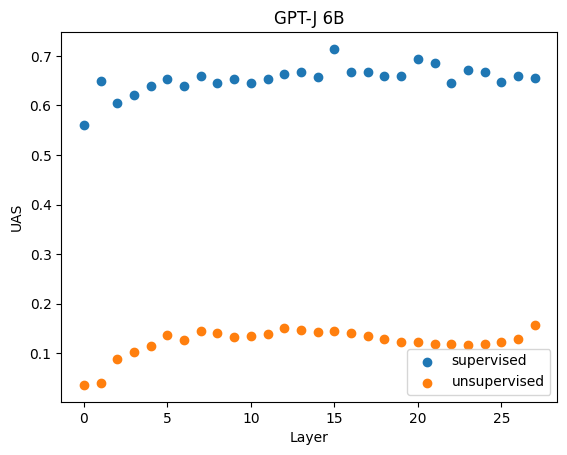

In [47]:
# fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# ax = axs[0]
for kwargs in sup_scatter_kwargs:
    plt.scatter(**kwargs)
for kwargs in unsup_scatter_kwargs:
    plt.scatter(**kwargs)

plt.xlabel('Layer')
plt.ylabel('UAS')
plt.title('GPT-J 6B')
plt.legend()
# ax = axs[1]
# ax.set_xlabel('Layer')
# ax.set_ylabel('UAS')
# ax.set_title('Unsupervised')


    # all_scatter_kwargs, all_annotations = get_kwargs_for_test_suite(test_suite)
    # ax = axs[i % 2, i // 2]  # Swap the row and column indices

    # for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
    #     ax.scatter(**kwargs)
    #     ax.annotate(**annotations)

    # ax.set_xlabel('SG Surprisal')
    # ax.set_ylabel('Head Word Probe UAS')
    # ax.set_title(test_suite)
    # ax.grid(True)
plt.savefig(f'final_plots/{model_name.replace("/", "-")}_sxs.png')

In [66]:
import collections
universal_deps = [
    'nsubj',
    'obj',
    'iobj',
    'appos',
    'nmod',
    'det',
    'nummod',
    'punct',
    'compound',
    'conj',
    'amod',
    'advmod',
    'obl'
]
prev_totals = None
RUNS = {
    "EleutherAI/pythia-2.8b": "91dqlyy8",
    "tiiuae/falcon-7b": "jcptmzek",
    "gpt2-large": "r0u0bjcz",
    "EleutherAI/gpt-j-6b": "81vkf85b",
    "meta-llama/Llama-2-7b-hf": "p16wh1qg",
    "gpt2-xl": "xozj5ub1",
    "mistralai/Mistral-7B-v0.1": "4hcvqiwu",
    "google/gemma-2b": "y2opgjol",
    "microsoft/phi-2": "v7711eze",
}
for model_name, run_id in RUNS.items():
    corrects = collections.Counter()
    totals = collections.Counter()
    run = api.run(f"ananthag/Head Word Final 2/{run_id}")
    for univ_dep in universal_deps:
        for key in run.summary_metrics.keys():
            if key.startswith(univ_dep) and key.endswith('correct'):
                corrects[univ_dep] += run.summary_metrics[key]
                totals[univ_dep] += run.summary_metrics[key.replace('correct', 'total')]
    if prev_totals:
        assert totals == prev_totals
    prev_totals = totals
    print(model_name)
    print(tuple(corrects.items()))

EleutherAI/pythia-2.8b
(('nsubj', 3163), ('obj', 1510), ('iobj', 62), ('appos', 250), ('nmod', 1988), ('det', 3853), ('nummod', 1169), ('punct', 4914), ('compound', 3330), ('conj', 599), ('amod', 2813), ('advmod', 1661), ('obl', 1557))
tiiuae/falcon-7b
(('nsubj', 3091), ('obj', 1333), ('iobj', 54), ('appos', 188), ('nmod', 1734), ('det', 3991), ('nummod', 1124), ('punct', 4416), ('compound', 3339), ('conj', 473), ('amod', 2848), ('advmod', 1751), ('obl', 1440))
gpt2-large
(('nsubj', 3393), ('obj', 1551), ('iobj', 59), ('appos', 240), ('nmod', 2001), ('det', 3920), ('nummod', 1175), ('punct', 5110), ('compound', 3452), ('conj', 622), ('amod', 2919), ('advmod', 1813), ('obl', 1646))
EleutherAI/gpt-j-6b
(('nsubj', 3206), ('obj', 1524), ('iobj', 70), ('appos', 267), ('nmod', 2062), ('det', 3883), ('nummod', 1188), ('punct', 4930), ('compound', 3366), ('conj', 603), ('amod', 2830), ('advmod', 1735), ('obl', 1613))
meta-llama/Llama-2-7b-hf
(('nsubj', 3445), ('obj', 1532), ('iobj', 57), ('app

In [67]:
totals

Counter({'punct': 7683,
         'det': 4663,
         'compound': 4470,
         'nsubj': 4276,
         'nmod': 3835,
         'amod': 3539,
         'obl': 3054,
         'advmod': 2292,
         'obj': 2197,
         'conj': 1487,
         'nummod': 1424,
         'appos': 567,
         'iobj': 77})

In [11]:
import os
import re
template_map = {
    "ML_simple_agrmt": "Simple",
    "ML_sent_comp": "In a sentential complement",
    "ML_vp_coord": "VP coordination",
    "ML_obj_rel_no_comp_across": "Across object relative (no that)",
    "ML_obj_rel_within": "In object relative clause",
    "ML_obj_rel_no_comp_within": "In object relative (no that)",
    "ML_prep": "Across prepositional phrase",
    "ML_obj": "Across object relative clause",
    "ML_subj": "Across subject relative clause",
    "blimp": "BLiMP",
}
columns = []
data = {
    k: [] for k in template_map.keys()
}
for model in os.listdir("refining-tse/results"):
    match model:
        case "gpt2-xl":
            model_name = "gpt2-xl"
        case "EleutherAI-pythia-2.8b":
            model_name = "EleutherAI/pythia-2.8b"
        case "google-gemma-2b":
            model_name = "google/gemma-2b"
        case "meta-llama-Llama-2-7b-hf":
            model_name = "meta-llama/Llama-2-7b-hf"
        case "EleutherAI-gpt-j-6b":
            model_name = "EleutherAI/gpt-j-6b"
        case "microsoft-phi-2":
            model_name = "microsoft/phi-2"
        case "mistralai-Mistral-7B-v0.1":
            model_name = "mistralai/Mistral-7B-v0.1"
        case "tiiuae-falcon-7b":
            model_name = "tiiuae/falcon-7b"
    for test_suite in os.listdir(f"refining-tse/results/{model}"):
        # Handle mw
        with open(f"refining-tse/results/{model}/{test_suite}/mw/custom_{model_name}_main/metrics/main.txt") as f:
            lines = f.readlines()
            score_line = lines[5]
            match = re.search(r"(\d+\.\d{1,3})", score_line)
            data[test_suite].append(float(match.group(1)))
            columns.append(f"{model_name}_mw")
        # Handle ew
        with open(f"refining-tse/results/{model}/{test_suite}/tse_ew/custom_{model_name}_ML-main/metrics/main.txt") as f:
            if 'llama' in model_name and (test_suite == "ML_obj_rel_no_comp_within" or test_suite == "ML_obj_rel_within"):
                score = 0.0
            else:
                print(model, test_suite)
                lines = f.readlines()
                score_line = lines[5]
                match = re.search(r"(\d+\.\d{1,3})", score_line)
                score = float(match.group(1))
                data[test_suite].append(score)
            columns.append(f"{model_name}_ew")
        # Handle tse
        with open(f"refining-tse/results/{model}/{test_suite}/tse/custom_{model_name}_ML-main/metrics/ML.txt") as f:
            lines = f.readlines()
            score_line = lines[5]
            match = re.search(r"(\d+\.\d{1,3})", score_line)
            data[test_suite].append(float(match.group(1)))
            columns.append(f"{model_name}_tse")
            



mistralai-Mistral-7B-v0.1 blimp
mistralai-Mistral-7B-v0.1 ML_obj_rel_within
mistralai-Mistral-7B-v0.1 ML_simple_agrmt
mistralai-Mistral-7B-v0.1 ML_vp_coord
mistralai-Mistral-7B-v0.1 ML_prep
mistralai-Mistral-7B-v0.1 ML_obj
mistralai-Mistral-7B-v0.1 ML_obj_rel_no_comp_within
mistralai-Mistral-7B-v0.1 ML_subj
mistralai-Mistral-7B-v0.1 ML_obj_rel_no_comp_across
mistralai-Mistral-7B-v0.1 ML_sent_comp
EleutherAI-gpt-j-6b ML_subj
EleutherAI-gpt-j-6b ML_obj
EleutherAI-gpt-j-6b ML_vp_coord
EleutherAI-gpt-j-6b ML_sent_comp
EleutherAI-gpt-j-6b ML_obj_rel_within
EleutherAI-gpt-j-6b blimp
EleutherAI-gpt-j-6b ML_obj_rel_no_comp_within
EleutherAI-gpt-j-6b ML_prep
EleutherAI-gpt-j-6b ML_simple_agrmt
EleutherAI-gpt-j-6b ML_obj_rel_no_comp_across
tiiuae-falcon-7b ML_subj
tiiuae-falcon-7b ML_obj_rel_within
tiiuae-falcon-7b ML_simple_agrmt
tiiuae-falcon-7b blimp
tiiuae-falcon-7b ML_obj_rel_no_comp_across
tiiuae-falcon-7b ML_vp_coord
tiiuae-falcon-7b ML_prep
tiiuae-falcon-7b ML_obj
tiiuae-falcon-7b ML_obj

In [5]:
from transformers import AutoTokenizer

t5_tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-base", use_fast=False)

/nlp/scr/ananthag/miniconda3/envs/syntax/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
t5_tokenizer(["hi", "hi hi hi"], return_tensors='pt', padding=True)

{'input_ids': tensor([[7102,    1,    0,    0],
        [7102, 7102, 7102,    1]]), 'attention_mask': tensor([[1, 1, 0, 0],
        [1, 1, 1, 1]])}

In [12]:
t5_tokenizer.eos_token_id

1